# Models

Matt Thomas, Max McGaw, Liam Mulcahy, Will Carruthers

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [43]:
%matplotlib inline

In [3]:
#We can use the sample.csv to speed things up while tuning models
#df = spark.read.csv('train_data.csv', inferSchema=True, header=True)
df = spark.read.csv('sample.csv', inferSchema=True, header=True)

In [4]:
df.show(2)

+------+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+
|   _c0|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_CD|grade_EFG|emp_length_low|
+------+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+
|625057|                 0|  35000.0| 36 months|    7.99|      MORTGAGE|   456527.0|   38768.76|  250000.0|        MI|         775.0|        2165.42|       0|        0|             0|
|394994|                 0|   8000.0| 36 months|   11.49|          RENT|    35497.0|   8643.126|   50000.0|        CA|         670.0|         6543.1|       0|        0|             0|
+------+------------------+---------+----------+--------+--------------+--------

In [5]:
dfs = df.select([col for col in df.columns if col not in ['_c0']])

In [6]:
dfs.show(5)

+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_CD|grade_EFG|emp_length_low|
+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+
|                 0|  35000.0| 36 months|    7.99|      MORTGAGE|   456527.0|   38768.76|  250000.0|        MI|         775.0|        2165.42|       0|        0|             0|
|                 0|   8000.0| 36 months|   11.49|          RENT|    35497.0|   8643.126|   50000.0|        CA|         670.0|         6543.1|       0|        0|             0|
|                 0|  35000.0| 36 months|   10.08|      MORTGAGE|   424094.0|    8340.06|  126000.0|        NJ|    

In [7]:
dfs.printSchema()

root
 |-- loan_status_binary: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- tot_cur_bal: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- fico_range_low: double (nullable = true)
 |-- last_pymnt_amnt: double (nullable = true)
 |-- grade_CD: integer (nullable = true)
 |-- grade_EFG: integer (nullable = true)
 |-- emp_length_low: integer (nullable = true)



In [8]:
dfs.filter(dfs['tot_cur_bal'].isNull()).count()
#Need to do something abou this

20922

In [9]:
train, test = dfs.randomSplit([0.8, 0.2], seed=12345)

In [10]:
categories = ['home_ownership', 'term']
stages = []

In [11]:
for col in categories:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=col + "classVec")
    stages += [stringIndexer, encoder]

In [12]:
scaled_vectors = VectorAssembler(inputCols = ['loan_amnt',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low'], 
                                 outputCol='vector_features')

In [13]:
scaler = StandardScaler(inputCol='vector_features', outputCol='scaled_features')
#scaler = StandardScaler(inputCol='vector_features', outputCol='scaled_features')

In [14]:
labelIndexer = StringIndexer(inputCol='loan_status_binary', outputCol='label')

In [15]:
#AT added
assembler = VectorAssembler(inputCols=['scaled_features', 'home_ownershipclassVec', 'termclassVec', 'grade_EFG', 'grade_CD' ], outputCol='features')

In [16]:
stages += [scaled_vectors, scaler, labelIndexer, assembler]

In [17]:
# AT commented
#assembler = VectorAssembler(inputCols=['scaled_features', 'home_ownershipclassVec',\
#                                       'grade_CD', 'termclassVec',\
#                                       'grade_EFG'], outputCol='features')
#stages += [scaler, labelIndexer, assembler]

In [18]:
lr = LogisticRegression(maxIter=10, regParam=0.1)
stages += [lr]
stages

[StringIndexer_347e0763c653,
 OneHotEncoder_13b4bdc3ec86,
 StringIndexer_3bdb0405f385,
 OneHotEncoder_d264d22ff9bc,
 VectorAssembler_8cde54b14ac3,
 StandardScaler_d32d2c76d1d3,
 StringIndexer_bde90a96642d,
 VectorAssembler_c91c2f6f9def,
 LogisticRegression_dd0ee69f481e]

In [19]:
pipeline = Pipeline(stages=stages)

In [20]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.5, 0.3, 0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.8, 1.0])\
    .build()

In [21]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

In [22]:
# Fit the pipeline
model = crossval.fit(train)

In [23]:
# Make a prediction
prediction = model.transform(test)
prediction.show(2)

+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+--------------------+----------------------+----------+-------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+----------+
|loan_status_binary|loan_amnt|      term|int_rate|home_ownership|tot_cur_bal|total_pymnt|annual_inc|addr_state|fico_range_low|last_pymnt_amnt|grade_CD|grade_EFG|emp_length_low|home_ownership_Index|home_ownershipclassVec|term_Index| termclassVec|     vector_features|     scaled_features|label|            features|       rawPrediction|         probability|prediction|
+------------------+---------+----------+--------+--------------+-----------+-----------+----------+----------+--------------+---------------+--------+---------+--------------+--------------------+----------------------+----------+-------------+-------------------

In [24]:
prediction = prediction.withColumn("loan_status_binary", df["loan_status_binary"].cast('float'))
#This is necessary to compare predictions with actual values

In [25]:
matches = prediction.filter(prediction['loan_status_binary'] == prediction['prediction']).count()

In [26]:
#Calculates area under Precision-Recall curve
evaluator = BinaryClassificationEvaluator(labelCol='loan_status_binary', \
                                          metricName='areaUnderPR')

In [27]:
evaluator.evaluate(prediction) #calculates area under P-R curve

0.31943122312407446

In [28]:
counts = prediction.count()

In [29]:
accuracy = matches / counts
print(f"accuracy = {accuracy}")

accuracy = 0.8813656471833159


In [30]:
f1_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',\
                                                 labelCol='loan_status_binary',\
                                                 metricName='f1')

In [31]:
f1_evaluator.evaluate(prediction) #f1 score

0.8327924225756679

In [34]:
trainingSummary = model.bestModel.stages[-1].summary

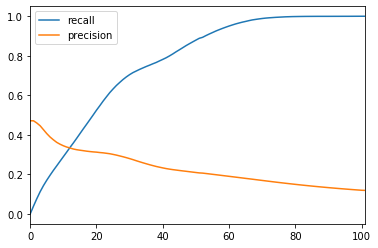

In [44]:
#plotting precision-recall curve
pr = trainingSummary.pr.toPandas()
pr.plot()


In [37]:
!jupyter nbconvert --to pdf '../Spark_ML_DS5559'/*.ipynb

[NbConvertApp] Converting notebook ../Spark_ML_DS5559/Final_Project_DS5559_data.ipynb to pdf
[NbConvertApp] Support files will be in Final_Project_DS5559_data_files/
[NbConvertApp] Making directory ./Final_Project_DS5559_data_files
[NbConvertApp] Writing 80572 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 96996 bytes to ../Spark_ML_DS5559/Final_Project_DS5559_data.pdf
[NbConvertApp] Converting notebook ../Spark_ML_DS5559/Project_Models.ipynb to pdf
[NbConvertApp] Writing 43276 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNIN